In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(50, 145, 96)

df = pd.read_csv('2017-03-16_PRO_single_well_inference_input_multi_well_t_50.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((96,5))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)

print(st_dev)

print(np.mean(org_values, axis=1))
print(centred_moment_3)

# print(centred_moments.shape)


[25.39275684 25.80896356 24.27476622 24.70051568 24.60447673 23.72365644
 23.59923939 23.41692764 23.07736987 23.09031128 23.33827329 21.81983673
 22.3851128  22.18839787 21.23303087 20.32610637 20.93601204 20.63781178
 20.54495315 19.56677286 19.06461119 18.96993608 19.16737071 19.26087939
 19.06362702 18.16990369 17.16667994 16.87088839 16.28551811 17.10717613
 16.78941929 16.30822185 15.88066356 15.44583763 15.06480916 15.0547534
 14.88602029 14.30096063 13.95240033 14.1191811  13.71756083 13.35635055
 13.28540082 12.86519627 12.81568863 12.45419106 12.31403569 12.0882174 ]
[5.73  5.82  5.615 5.705 5.665 5.625 5.53  5.55  5.5   5.505 5.6   5.335
 5.435 5.4   5.28  5.12  5.22  5.115 5.07  4.92  4.84  4.845 4.87  4.855
 4.775 4.64  4.51  4.475 4.37  4.455 4.48  4.37  4.295 4.19  4.155 4.12
 4.08  3.995 3.945 3.965 3.855 3.77  3.775 3.685 3.675 3.575 3.545 3.5  ]
[ 99124.486284   102452.003736    83881.75855425  88392.24911775
  85581.98852175  75805.67484375  76092.426804    73234.992

Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 1
noise_arr[2] = 1
noise_arr[3] = 1
noise_arr[4] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.000001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 100
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_21940/1562655438.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     522     0:01.4
2     1014    0:02.6
3     1530    0:03.7
20    8697    0:19.2
40    15582   0:34.7
60    21855   0:49.1
80    28095   1:03.3
100   34287   1:17.4
120   40488   1:31.5
140   46680   1:45.6
160   52839   1:59.6
180   59331   2:14.4
200   65715   2:28.8
220   72024   2:43.1
240   78012   2:56.9
260   84090   3:10.8
280   90360   3:25.5
300   96663   3:40.1
320   103011   3:55.0
340   109176   4:09.5
360   115620   4:24.5
380   122115   4:39.1
400   128256   4:53.1
420   134457   5:07.3
440   140358   5:21.0
460   146436   5:35.0
480   153078   5:50.4
500   159225   6:04.6
520   165603   6:19.1
540   171819   6:33.0
560   178113   6:47.3
580   184248   7:01.1
600   190509   7:15.3
620   196854   7:29.9
640   203118   7:44.5
660   209307   7:58.4
680   215364   8:12.2
700   221721   8:26.9
720   228051   8:41.3
740   234213   8:55.4
760   240171   

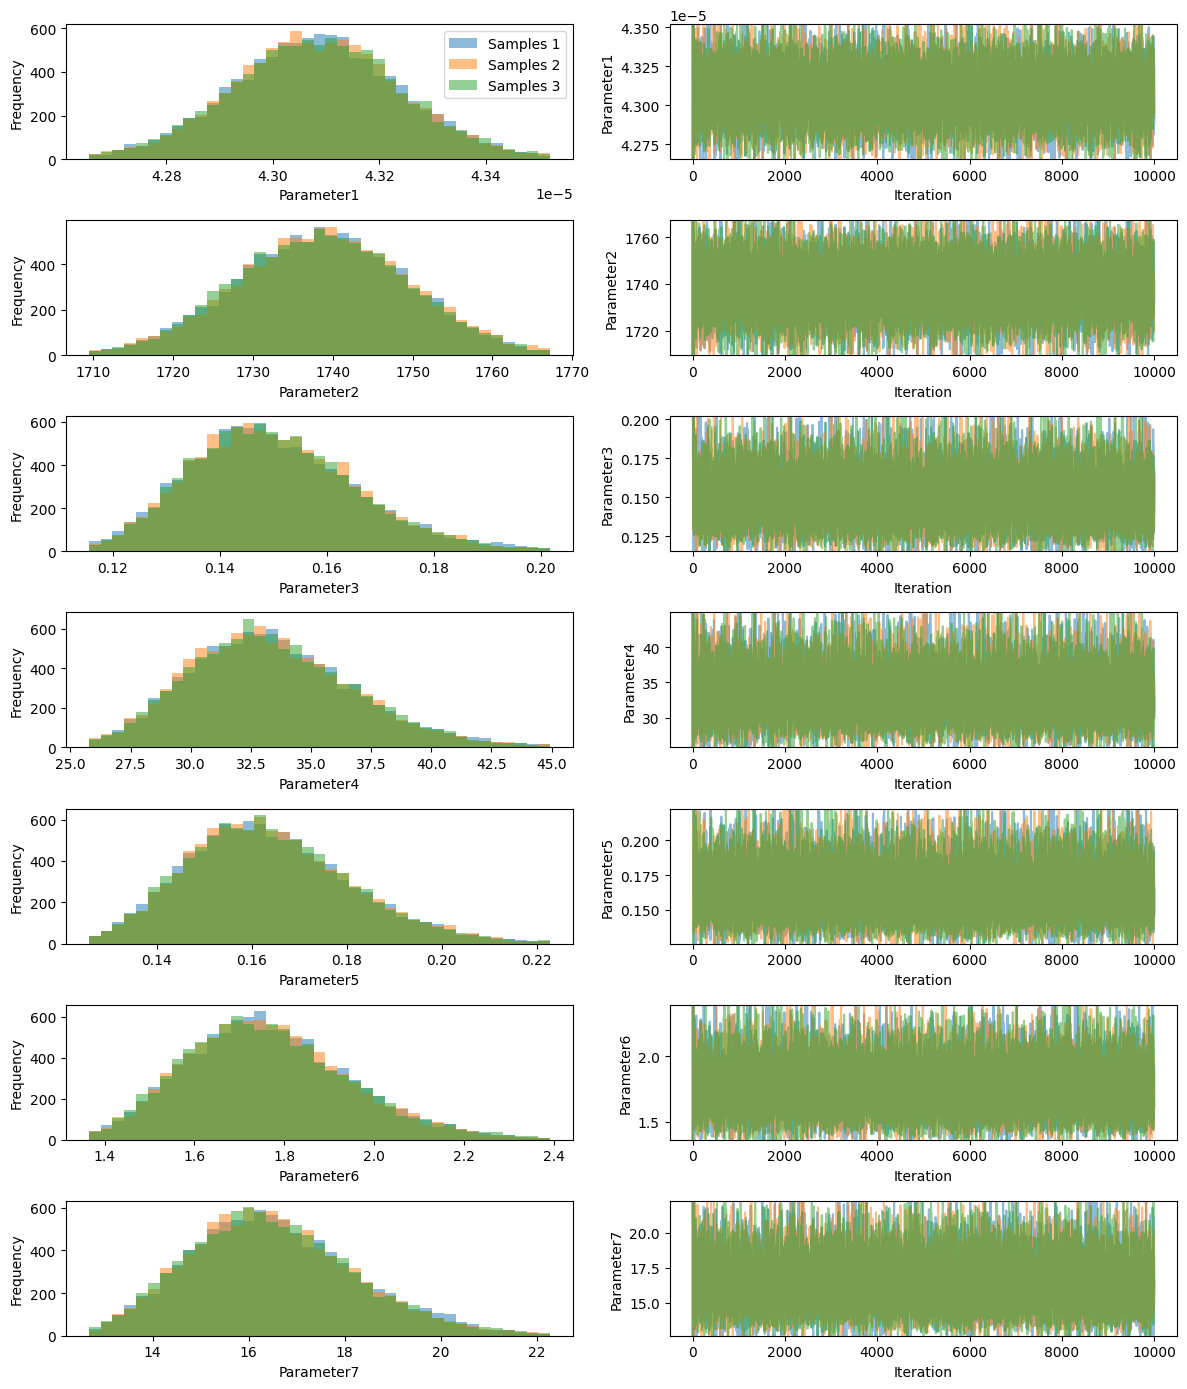

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [21]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(9900, 7)
[4.31788244e-05 1.74562688e+03 1.31576392e-01 3.11414892e+01
 1.80136466e-01 1.73706957e+00 1.67594691e+01]
[[4.31788244e-05 1.74562688e+03 1.31576392e-01 ... 1.80136466e-01
  1.73706957e+00 1.67594691e+01]
 [4.29164317e-05 1.74190260e+03 1.51723458e-01 ... 1.47735909e-01
  1.81017462e+00 1.52789484e+01]
 [4.31375063e-05 1.73359278e+03 1.46102903e-01 ... 1.63452531e-01
  1.79401727e+00 1.52902476e+01]
 ...
 [4.28840110e-05 1.74355615e+03 1.51581322e-01 ... 1.44481468e-01
  1.90856192e+00 1.60661704e+01]
 [4.30324395e-05 1.74350900e+03 1.69246560e-01 ... 1.52580199e-01
  1.82088649e+00 1.56113269e+01]
 [4.28959767e-05 1.73400592e+03 1.30198337e-01 ... 1.64875494e-01
  1.61702244e+00 1.82277071e+01]]


In [22]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


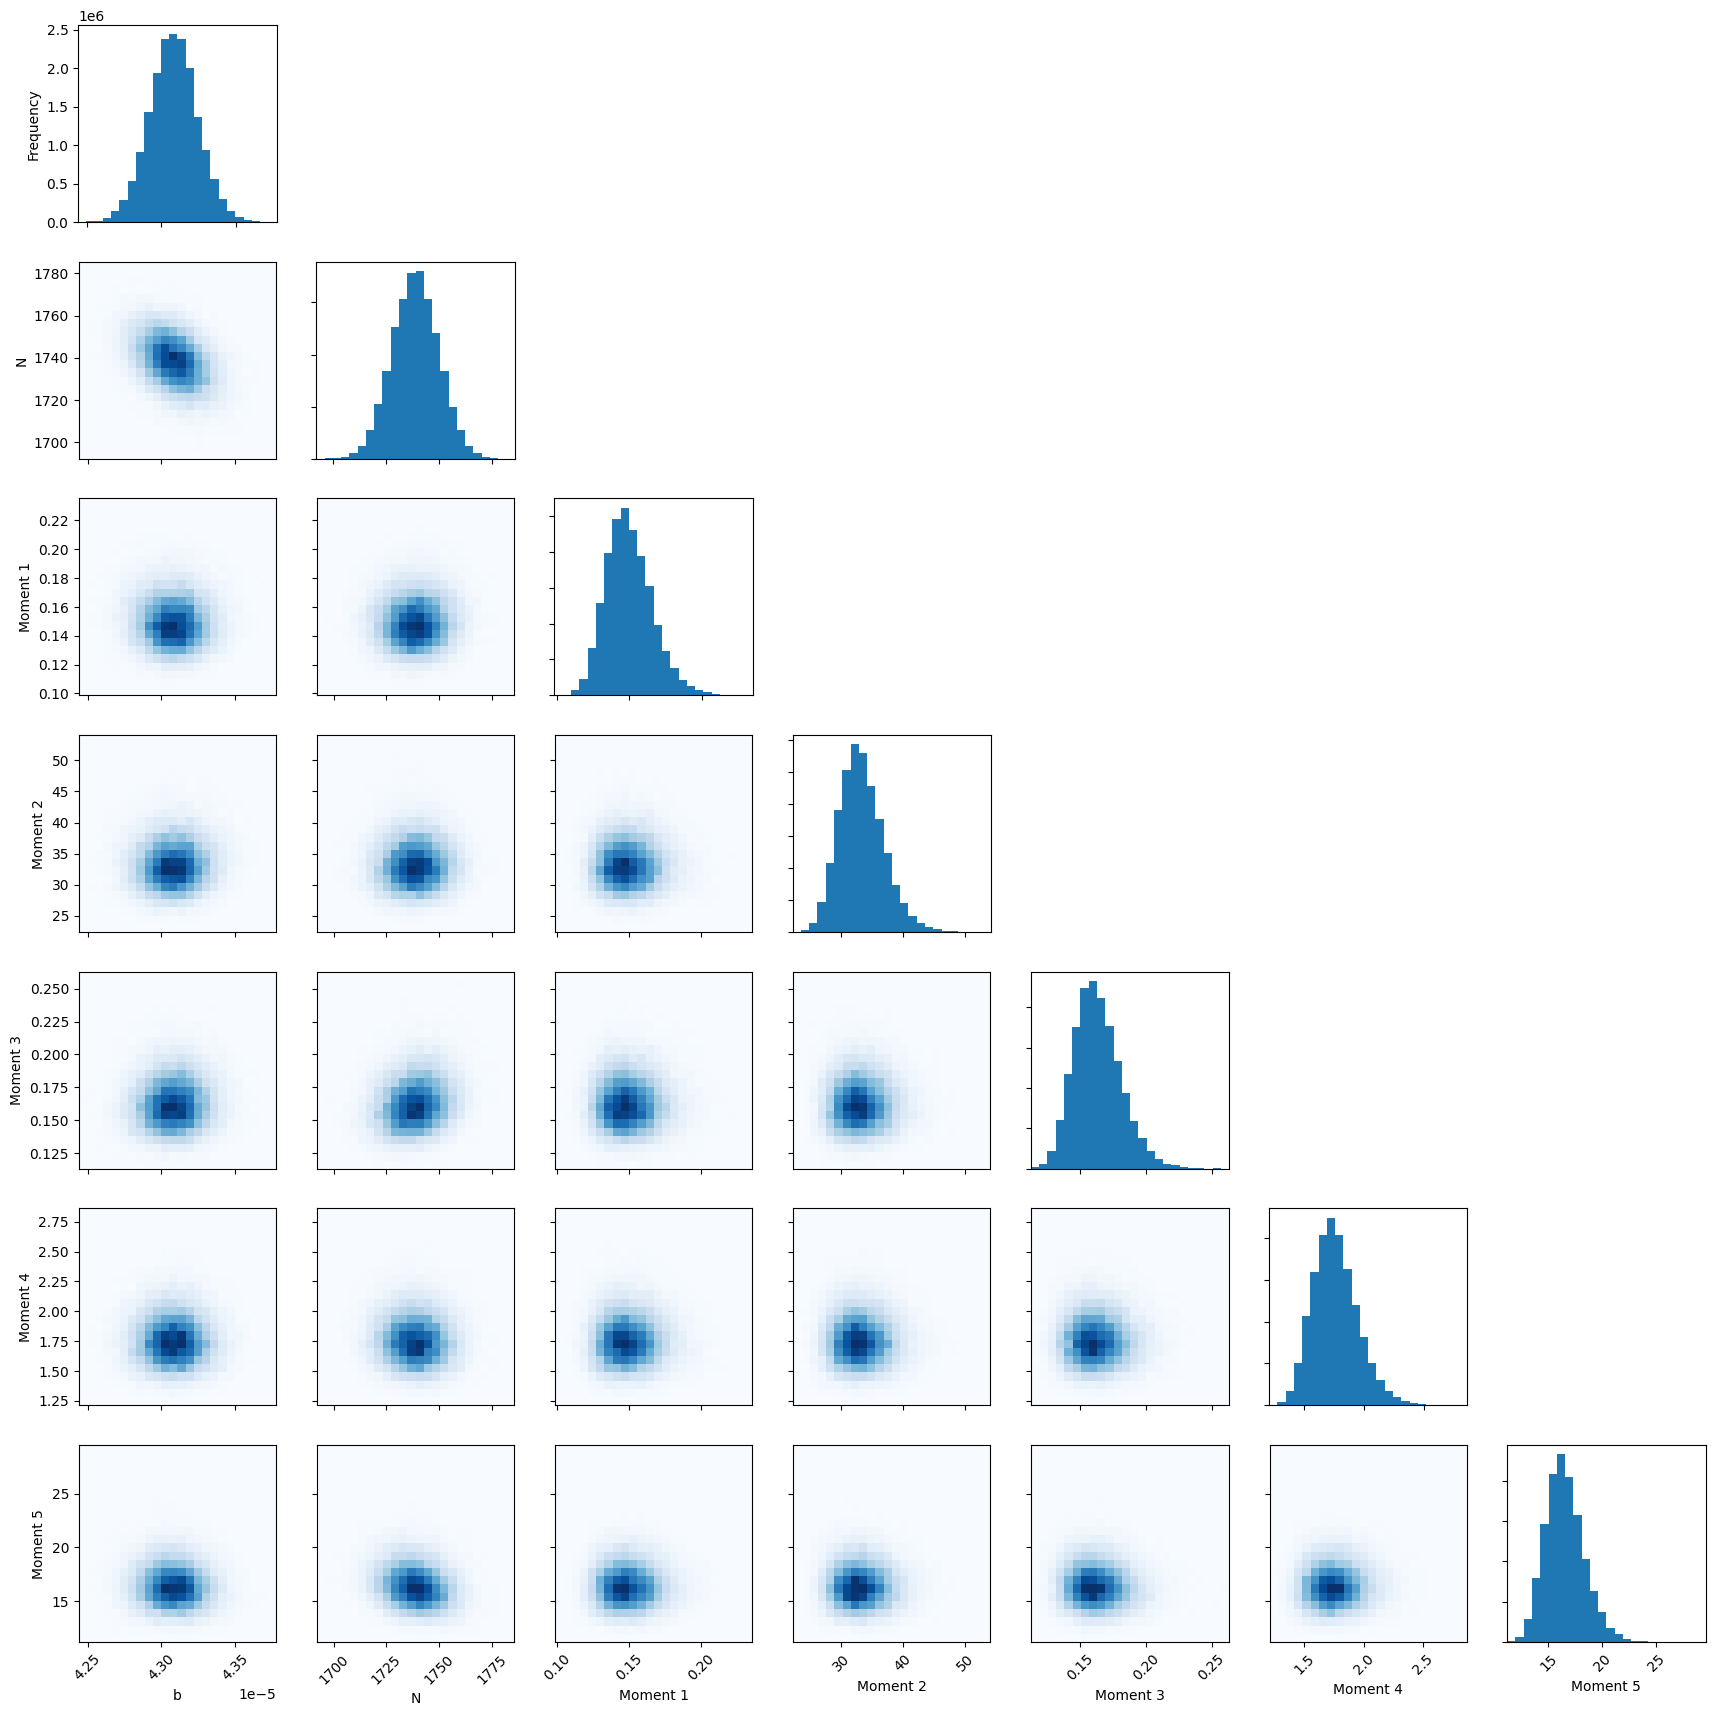

In [23]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

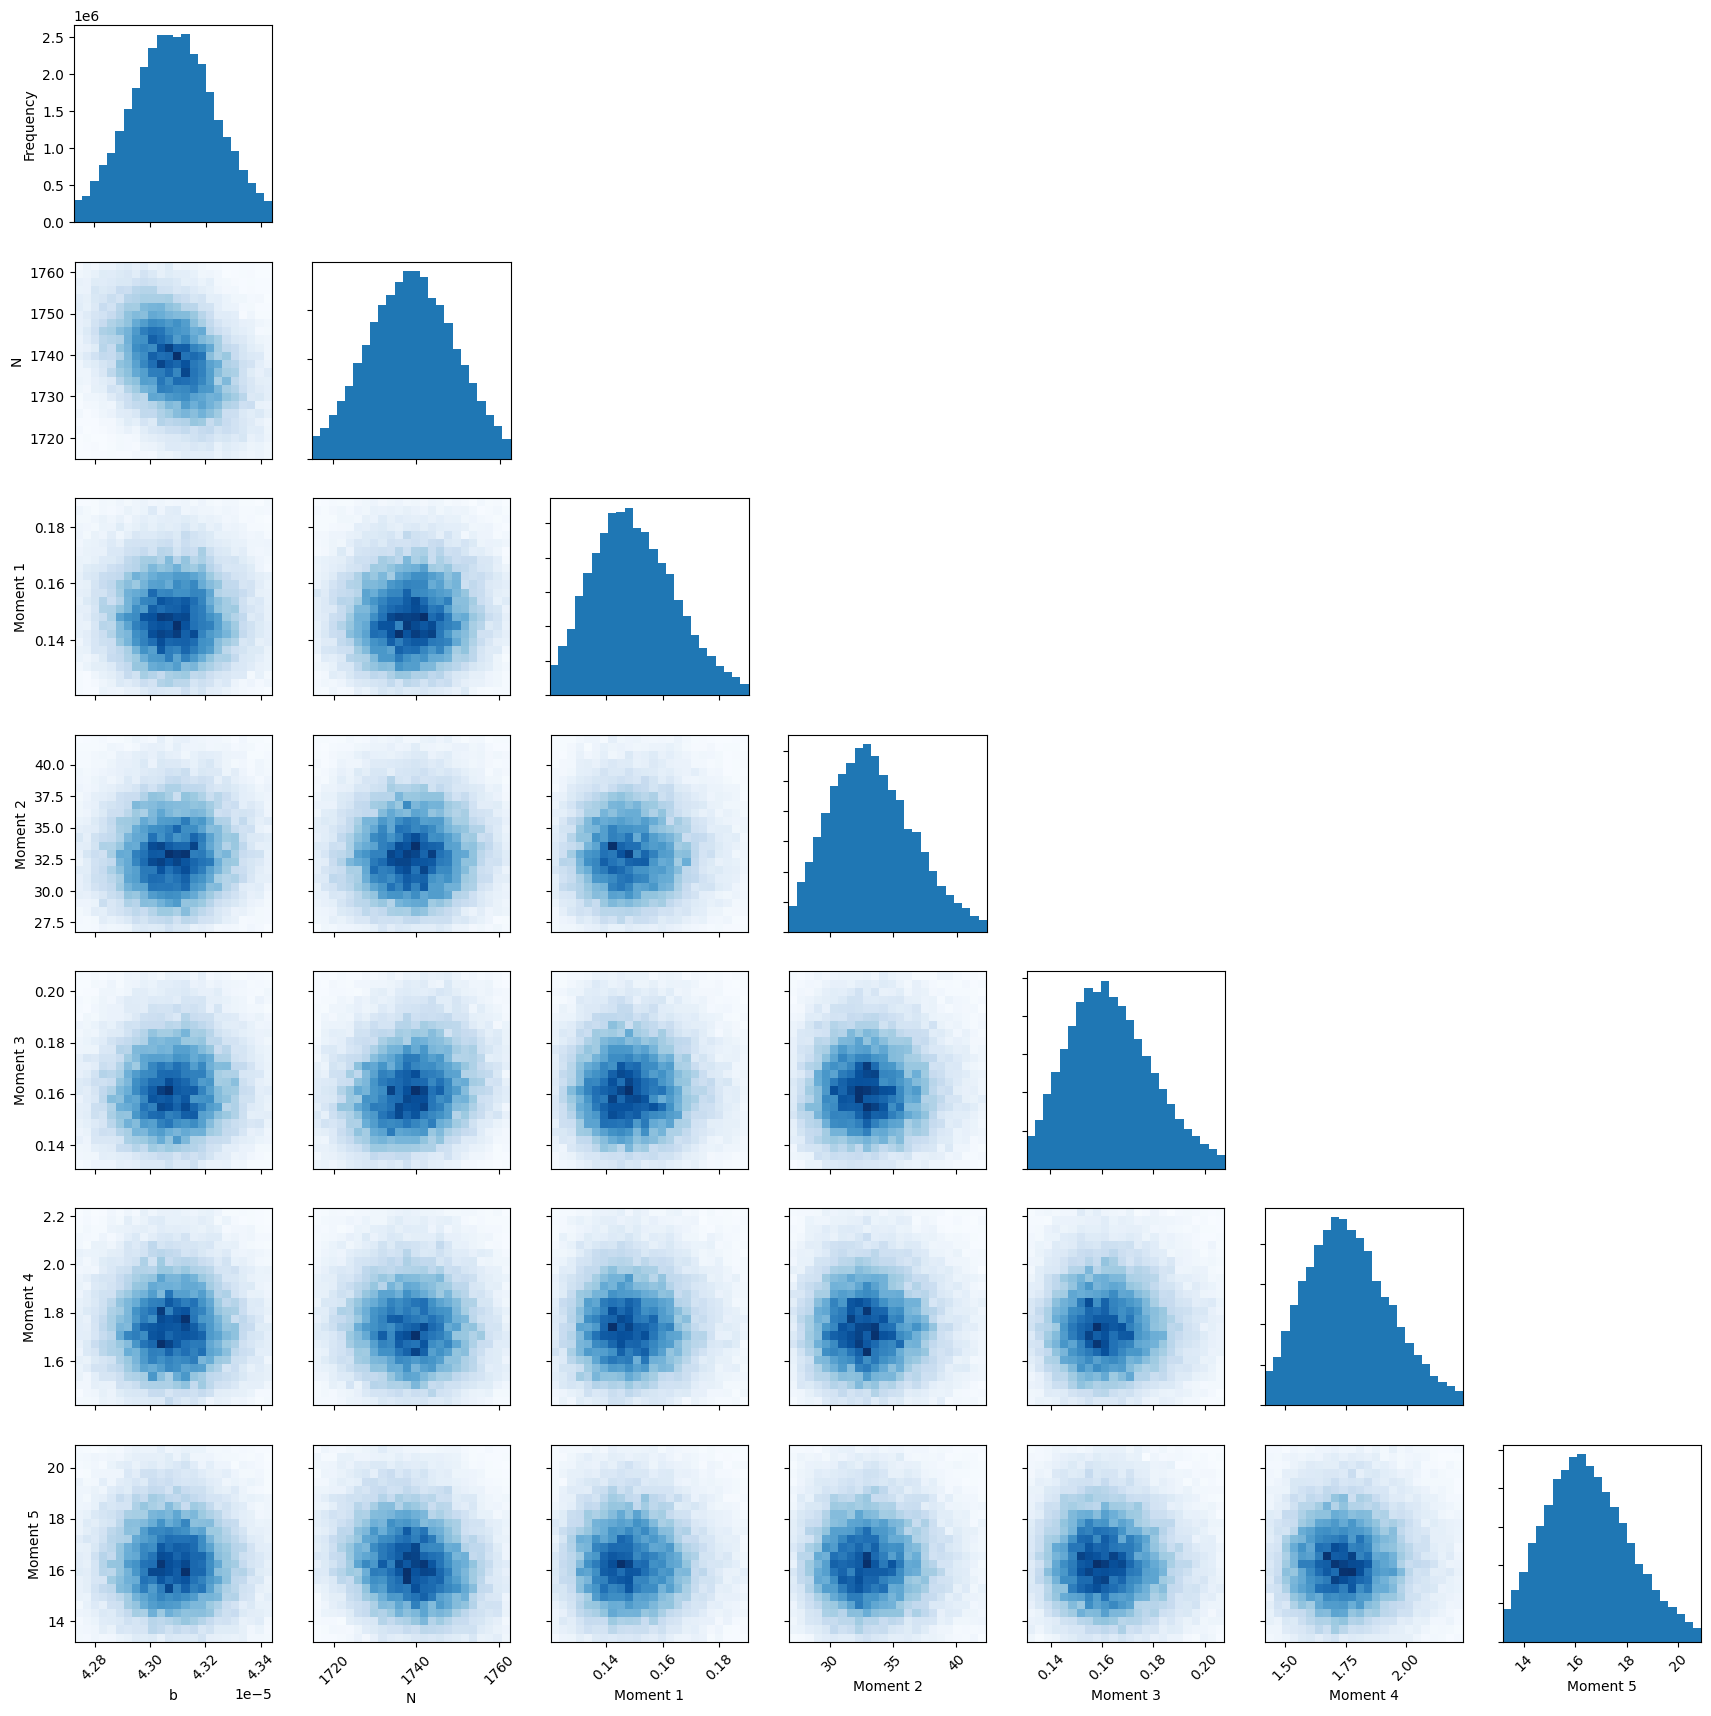

In [24]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
                    
plt.show()

[4.31788244e-05 1.74562688e+03 1.31576392e-01 3.11414892e+01
 1.80136466e-01 1.73706957e+00 1.67594691e+01]


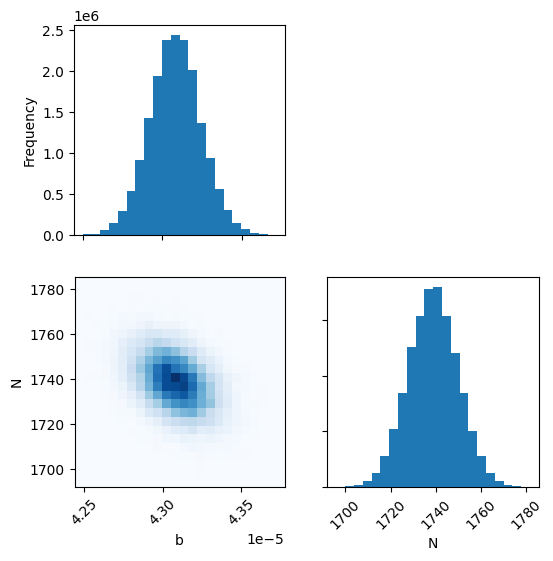

In [25]:
parameter_names = ["b","N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1]], heatmap=True, 
                    parameter_names=["b","N"])
plt.savefig("Pints_pairwise_pro_params_only.png", dpi =300)
plt.show()


In [13]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess      ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  -------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    4357.97  0.56
N         1738.84  11.06   1717.38  1731.29  1738.83  1746.35  1760.39  1.00    4201.19  0.54
Moment 1  0.15     0.02    0.12     0.14     0.15     0.16     0.19     1.00    4587.05  0.59
Moment 2  33.39    3.56    27.32    30.89    33.06    35.61    41.15    1.00    4445.56  0.57
Moment 3  0.16     0.02    0.13     0.15     0.16     0.17     0.20     1.00    4604.78  0.59
Moment 4  1.77     0.19    1.44     1.63     1.75     1.88     2.18     1.00    4608.73  0.59
Moment 5  16.51    1.80    13.42    15.24    16.36    17.63    20.42    1.00    4437.03  0.57


In [14]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [15]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  --------  --------------
b         4.31e-05  1.62e-07  4.28e-05  4.3e-05   4.31e-05  4.32e-05  4.34e-05  1       4.36e+03  0.558
N         1.74e+03  11.1      1.72e+03  1.73e+03  1.74e+03  1.75e+03  1.76e+03  1       4.2e+03   0.538
Moment 1  0.15      0.016     0.123     0.139     0.149     0.16      0.185     1       4.59e+03  0.587
Moment 2  33.4      3.56      27.3      30.9      33.1      35.6      41.2      1       4.45e+03  0.569
Moment 3  0.164     0.0177    0.134     0.151     0.163     0.175     0.202     1       4.6e+03   0.59
Moment 4  1.77      0.188     1.44      1.63      1.75      1.88      2.18      1       4.61e+03  0.59
Moment 5  16.5      1.8       13.4      15.2      16.4      17.6      20.4      1       4.44e+03  0.568


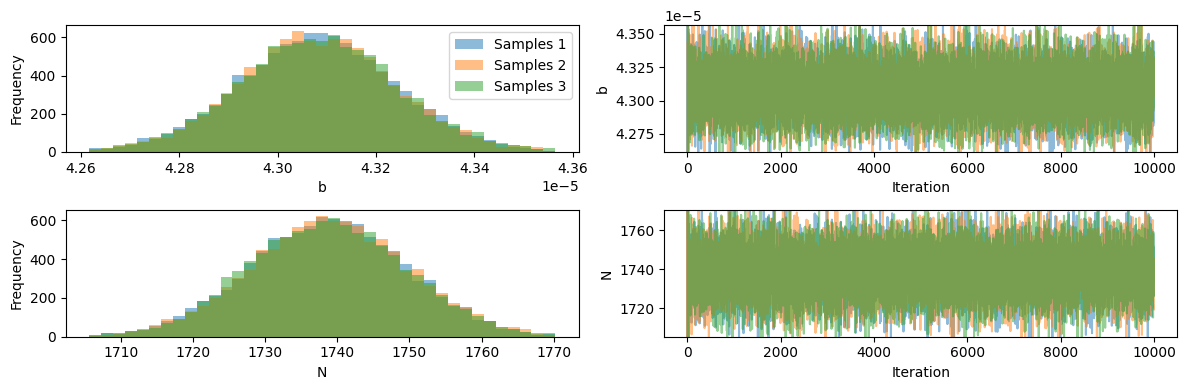

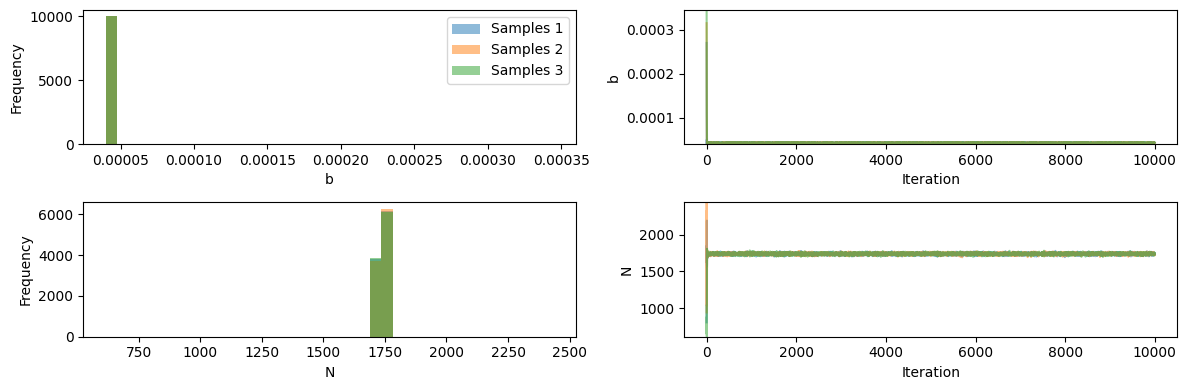

In [16]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()